**Train the BioNER model on N2C2 2018 Track 2 dataset using Clinical-BERT. Save to /model**

**TODO**
- Better overlap filtering
- Error analysis
- Merge train & val, validate on test

**Data versions**
- v1 = Arbitrary 300-length input to model
- v5 = Sentence based input to model
- v8 = Overlap tag filtered with sentence based input to model

**Model versions**
- v1 = ClinicalBERT with finetuning(with data v1) "emilyalsentzer/Bio_ClinicalBERT"
- v2 = BioBERT with finetuning(with data v1) "dmis-lab/biobert-v1.1"
- v3 = BERT with finetuning(with data v1)
- v7 =  Bio_Discharge_Summary_BERT (with data v8)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Initialize Parameters


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive/projects/biomedical_ner/model'

RandomOverSample  v1_cbBERT_v1data  v3_BERT_v1data     v9_LossWithWeights
UnderSampleOTags  v2_bBERT_v1data   v7_bdsBERT_v5data


In [ ]:
DATA_VER = "UnderSampleOTags"
MODEL_VER = "UnderSampleOTags" 
PARENT_DIR = "/content/gdrive/My Drive/projects/biomedical_ner"
DATA_DIR = PARENT_DIR + "/data/" + DATA_VER
MODEL_DIR = PARENT_DIR + "/model/" + MODEL_VER
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/val"
OUTPUT_DIR = PARENT_DIR + "/output/" + MODEL_VER

MODEL_PATH = MODEL_DIR + "/pytorch_model.bin"
CONFIG_PATH = MODEL_DIR + "/config.json"
VOCAB_PATH = MODEL_DIR + "/vocab.txt"
CLINICAL_BERT = "emilyalsentzer/Bio_Discharge_Summary_BERT"

In [ ]:
import os
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

In [ ]:
batch_size = 8
max_len = 384
epochs = 8
max_grad_norm = 1.0
full_finetuning = True

# Requirements Installation

In [ ]:
!pip install seqeval
!pip install transformers

     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=06cb8267a1e26a96d8e16b4123420ed11615b34c95cc6fcc64f50ee3f9d29f4a
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
     |████████████████████████████████| 1.3MB 11.2MB/s 
     |████████████████████████████████| 1.1MB 48.7MB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
     |████████████████████████████████| 890kB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4f07a1283c413109a560a97d88051125397193464254e447499f670f1357e610
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [ ]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import DataLoader, SequentialSampler, Dataset, ConcatDataset
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, AdamW, BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Check library version
!pip list | grep -E 'transformers|torch|Keras'

Keras                         2.4.3          
Keras-Preprocessing           1.1.2          
torch                         1.6.0+cu101    
torchsummary                  1.5.1          
torchtext                     0.3.1          
torchvision                   0.7.0+cu101    
transformers                  3.4.0          


# Setup Mapping

In [ ]:
tag2idx = {'B-Drug': 0,
          'I-Drug': 1,
          'B-Reason': 2,
          'I-Reason': 3,
          'B-ADE': 4,
          'I-ADE': 5,
          'O': 6,
          'X': 7,
          '[CLS]': 8,
          '[SEP]': 9
          }
tag2name = {tag2idx[key] : key for key in tag2idx}
class_weights = torch.tensor([3.9, 5.6, 5.4, 5.5, 6.8, 6.9, 1, 0, 1, 1])

# Setup GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

# Prepare Data- Load, Concatenate, Tokenize

In [ ]:
!ls '$TRAIN_DIR' | wc -l

265


In [ ]:
!ls '$VAL_DIR' | wc -l

38


In [ ]:
class ClinicalDataset(Dataset):
    def __init__(self, file, path, max_seq_len, tag2idx, tokenizer):
        self.max_seq_len = max_seq_len;
        self.path = os.path.join(path, file)
        self.df = pd.read_csv(self.path, names=['patientID', 'sentenceID', 'token', 'tag'], keep_default_na=False)
        self.tag2idx = tag2idx
        self.tokenizer = tokenizer
        # Convert Tokens to indices
        self.prepare_data()

    def prepare_data(self):
        sentences, labels = self.get_sentences(self.df)
        tokenized_texts, word_piece_labels = self.tokenize_text(sentences, labels)

        # Make text token into id
        input_ids = pad_sequences([self.tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                                  maxlen=self.max_seq_len, dtype="long", truncating="post", padding="post")

        # Make label into id, pad with "X" meaning others/wrong
        tags = pad_sequences([[tag2idx[l] for l in lab] for lab in word_piece_labels],
                             maxlen=self.max_seq_len, value=self.tag2idx["X"],
                             padding="post", dtype="long", truncating="post")

        # For fine tune of predict, with token mask is 1,pad token is 0
        attention_masks = [[int(i > 0) for i in ii] for ii in input_ids]

        self.Sentences = torch.tensor(input_ids)
        self.label_data = torch.tensor(tags)
        self.attention_masks = torch.tensor(attention_masks)

    def get_sentences(self, data):
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(), s["tag"].values.tolist())]
        grouped = data.groupby("sentenceID").apply(agg_func)
        tokenstags = [s for s in grouped]
        sentences = [[s[0] for s in sent] for sent in tokenstags]
        labels = [[s[1] for s in sent] for sent in tokenstags]
        return sentences, labels

    def tokenize_text(self, sentences, labels):
        tokenized_texts = []
        word_piece_labels = []
        i_inc = 0
        for word_list, label in (zip(sentences,labels)):
            temp_label = []
            temp_token = []

            # Add [CLS] at the front
            temp_label.append('[CLS]')
            temp_token.append('[CLS]')

            for word,lab in zip(word_list,label):
                token_list = self.tokenizer.tokenize(word)
                for m,token in enumerate(token_list):
                    temp_token.append(token)
                    temp_label.append(lab)

            # Add [SEP] at the end
            temp_token.append('[SEP]')
            temp_label.append('[SEP]')

            tokenized_texts.append(temp_token)
            word_piece_labels.append(temp_label)

        return tokenized_texts, word_piece_labels

    def __len__(self):
        return len(self.Sentences)

    def __getitem__(self, idx):
        return self.Sentences[idx], self.attention_masks[idx], self.label_data[idx]

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(CLINICAL_BERT, do_lower_case=False)

In [ ]:
# TRAIN DATASET
train_datasets = []

for doc in os.listdir(TRAIN_DIR):
    train_datasets.append(ClinicalDataset(doc, TRAIN_DIR, max_len, tag2idx, tokenizer))

# concatenate CSV data
train_dataset = ConcatDataset(train_datasets)

train_sampler = SequentialSampler(train_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,drop_last=True)

In [ ]:
# VAL DATASET
val_datasets = []

for doc in os.listdir(VAL_DIR):
    val_datasets.append(ClinicalDataset(doc, VAL_DIR, max_len, tag2idx, tokenizer))

# concatenate CSV data
val_dataset = ConcatDataset(val_datasets)

val_sampler = SequentialSampler(val_dataset)

val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size,drop_last=True)

# Train Model

In [ ]:
config = AutoConfig.from_pretrained(CLINICAL_BERT, num_labels=len(tag2idx), finetuning_task="ClinicalNER")
model = AutoModelForTokenClassification.from_config(config)

In [ ]:
model.cuda();
loss_weights = torch.FloatTensor(class_weights).cuda()

In [ ]:
if full_finetuning:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=1e-8)

In [ ]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
num_train_optimization_steps = int( math.ceil(len(train_dataset) / batch_size) / 1) * epochs

In [ ]:
print("***** Running training *****")
print("  Num examples = %d"%(len(train_dataset)))
print("  Batch size = %d"%(batch_size))
print("  Num steps = %d"%(num_train_optimization_steps))
loss_values, validation_loss_values = [], []
for _ in trange(epochs,desc="Epoch"):
    model.train();
    tr_loss = 0
    nb_tr_examples = 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels = b_labels)
        loss = outputs[0]
        

        # Custom loss calculation
        # logits = outputs[0]
        # loss = None
        # attention_mask = b_input_mask
        # labels = b_labels

        # loss_fct = CrossEntropyLoss(weight=loss_weights)
        # if attention_mask is not None:
        #     active_loss = attention_mask.view(-1) == 1
        #     active_logits = logits.view(-1, len(tag2idx))
        #     active_labels = torch.where(active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels))
        #     loss = loss_fct(active_logits, active_labels)
        # else:
        #     loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        

    # print and store train loss
    train_loss = (tr_loss / nb_tr_examples)
    loss_values.append(train_loss)
    print("Train loss: {}".format(train_loss))

    # VALIDATION STEP
    model.eval();
    val_loss = 0
    nb_eval_examples = 0
    predictions , true_labels = [], []

    for batch in val_dataloader:
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
          # forward pass
          outputs = model(b_input_ids, token_type_ids=None,
          attention_mask=b_input_mask, labels=b_labels)

        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the loss for this batch of test sentences.
        val_loss += outputs[0].item()
        nb_eval_examples += b_input_ids.size(0)
        
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
        
    eval_loss = (val_loss / nb_eval_examples)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))

    pred_tags = [[tag2name[p_i] for p_i, l_i in zip(p, l) if (tag2name[l_i] != "X" and tag2name[l_i] != "[CLS]" and tag2name[l_i] != "[SEP]")] for p, l in zip(predictions, true_labels)]
    valid_tags = [[tag2name[l_i] for l_i in l if (tag2name[l_i] != "X" and tag2name[l_i] != "[CLS]" and tag2name[l_i] != "[SEP]")] for l in true_labels]

    report = classification_report(valid_tags, pred_tags,digits=4)
    print("***** Eval results *****")
    print("\n%s"%(report))
    print("F1 score: %f"%(f1_score(valid_tags, pred_tags)))
    print("Accuracy score: %f"%(accuracy_score(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 1763
  Batch size = 8
  Num steps = 1768
Train loss: 0.041365005118264395
Validation loss: 0.023137844238511247


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.0000    0.0000    0.0000       240
        Drug     0.6240    0.6110    0.6174      6383
      Reason     0.5745    0.0593    0.1076       910

   micro avg     0.6233    0.5249    0.5699      7533
   macro avg     0.3995    0.2234    0.2417      7533
weighted avg     0.5981    0.5249    0.5362      7533



Epoch:  12%|█▎        | 1/8 [02:39<18:36, 159.52s/it]

F1 score: 0.569864
Accuracy score: 0.951194

Train loss: 0.029781562919643793
Validation loss: 0.02047661540057996
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.0000    0.0000    0.0000       240
        Drug     0.7082    0.6066    0.6535      6383
      Reason     0.4039    0.1363    0.2038       910

   micro avg     0.6921    0.5305    0.6006      7533
   macro avg     0.3707    0.2476    0.2858      7533
weighted avg     0.6489    0.5305    0.5784      7533



Epoch:  25%|██▌       | 2/8 [05:26<16:10, 161.71s/it]

F1 score: 0.600586
Accuracy score: 0.956270

Train loss: 0.027261754349720748
Validation loss: 0.02009622099728364
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.1176    0.0083    0.0156       240
        Drug     0.6766    0.6500    0.6630      6383
      Reason     0.3265    0.1747    0.2276       910

   micro avg     0.6495    0.5721    0.6084      7533
   macro avg     0.3736    0.2777    0.3021      7533
weighted avg     0.6165    0.5721    0.5898      7533



Epoch:  38%|███▊      | 3/8 [08:13<13:36, 163.23s/it]

F1 score: 0.608370
Accuracy score: 0.955646

Train loss: 0.025865839840844274
Validation loss: 0.019694895726507126
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.1831    0.0542    0.0836       240
        Drug     0.6800    0.6600    0.6698      6383
      Reason     0.3559    0.1615    0.2222       910

   micro avg     0.6546    0.5805    0.6154      7533
   macro avg     0.4063    0.2919    0.3252      7533
weighted avg     0.6250    0.5805    0.5971      7533



Epoch:  50%|█████     | 4/8 [10:59<10:57, 164.26s/it]

F1 score: 0.615352
Accuracy score: 0.956240

Train loss: 0.024881273605437442
Validation loss: 0.018886762033419116
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.2857    0.0500    0.0851       240
        Drug     0.7070    0.6394    0.6715      6383
      Reason     0.4338    0.1549    0.2283       910

   micro avg     0.6897    0.5621    0.6194      7533
   macro avg     0.4755    0.2814    0.3283      7533
weighted avg     0.6606    0.5621    0.5993      7533



Epoch:  62%|██████▎   | 5/8 [13:46<08:14, 164.99s/it]

F1 score: 0.619368
Accuracy score: 0.957868

Train loss: 0.023911535092206164
Validation loss: 0.01905304588802645
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.2326    0.0417    0.0707       240
        Drug     0.6648    0.6809    0.6728      6383
      Reason     0.3677    0.1725    0.2349       910

   micro avg     0.6441    0.5991    0.6208      7533
   macro avg     0.4217    0.2984    0.3261      7533
weighted avg     0.6152    0.5991    0.6007      7533



Epoch:  75%|███████▌  | 6/8 [16:32<05:30, 165.34s/it]

F1 score: 0.620770
Accuracy score: 0.956500

Train loss: 0.02316401637667282
Validation loss: 0.020035719083946035
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.2097    0.0542    0.0861       240
        Drug     0.6148    0.7258    0.6657      6383
      Reason     0.3367    0.1835    0.2376       910

   micro avg     0.5946    0.6389    0.6160      7533
   macro avg     0.3871    0.3212    0.3298      7533
weighted avg     0.5683    0.6389    0.5955      7533



Epoch:  88%|████████▊ | 7/8 [19:18<02:45, 165.52s/it]

F1 score: 0.615985
Accuracy score: 0.953580

Train loss: 0.022665660278025
Validation loss: 0.01972764817005752
***** Eval results *****

              precision    recall  f1-score   support

         ADE     0.1386    0.0583    0.0821       240
        Drug     0.6306    0.7163    0.6707      6383
      Reason     0.3208    0.1879    0.2370       910

   micro avg     0.6034    0.6315    0.6171      7533
   macro avg     0.3634    0.3208    0.3299      7533
weighted avg     0.5775    0.6315    0.5996      7533



Epoch: 100%|██████████| 8/8 [22:04<00:00, 165.61s/it]

F1 score: 0.617111
Accuracy score: 0.954345



# Save Model

In [ ]:
savemodel = model.module if hasattr(model, 'module') else model

torch.save(savemodel.state_dict(), MODEL_PATH)
savemodel.config.to_json_file(CONFIG_PATH)
tokenizer.save_vocabulary(MODEL_DIR)

('/content/gdrive/My Drive/projects/biomedical_ner/model/UnderSampleOTags/vocab.txt',)

In [ ]:
!ls '$MODEL_DIR'

config.json  pytorch_model.bin	vocab.txt


# Analyse

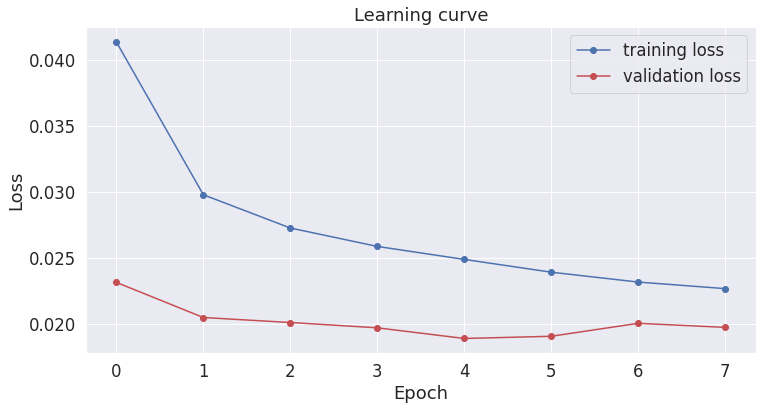

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig(OUTPUT_DIR + "/loss.png")

plt.show()

In [ ]:
!ls '$OUTPUT_DIR'

loss.png
